In [1]:
llema_file_path = "inference_competition_math_results/llemma_competition_math_extracted_answers_2.txt"

mistral_file_path = "inference_competition_math_results/Mistral_Inference_Competition_Dataset.csv"

llama_file_path = "inference_competition_math_results/inference_llama3_competition_math.csv"

qwen_file_path = "inference_competition_math_results/inference_QWEN_competition_math.csv"

In [2]:
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt

competition_math_dict = load_dataset("jeggers/competition_math", "original")
test_dataset = competition_math_dict["test"]
test_dataset_df = pd.DataFrame(test_dataset)
test_dataset_df["row_index"] = test_dataset_df.index

def format_llema_inference_competition_math():
    with open(llema_file_path, "r") as file:
        data = [eval(line.strip()) for line in file]
    df = pd.DataFrame(data)
    llema_test_dataset= df.merge(test_dataset_df, left_on='Iteration', right_on='row_index')
    llema_test_dataset["level:type"] = llema_test_dataset["level"] + ": " + llema_test_dataset["type"]

    llema_test_dataset["llema_is_correct"] =  (llema_test_dataset["Final Solution"] == llema_test_dataset["extracted_solution"])

    llema_test_dataset = llema_test_dataset.rename(columns={"Final Solution": "llema_solution"})

    llema_3_results = llema_test_dataset[["row_index", "level", "type", "llema_is_correct", "llema_solution"]]
    return llema_3_results

def format_mistral_inference_competition_math():
    df = pd.read_csv(mistral_file_path)
    mistral_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    mistral_test_dataset["mistral_is_correct"] = (mistral_test_dataset["Run_1"] == mistral_test_dataset["extracted_solution"])
    mistral_test_dataset["level:type"] = mistral_test_dataset["level"] + ": " + mistral_test_dataset["type"]

    mistral_test_dataset = mistral_test_dataset.rename(columns={"Run_1": "mistral_solution"})

    mistral_results = mistral_test_dataset[["row_index", "level", "type", "mistral_is_correct", "mistral_solution"]]
    return mistral_results    

def format_llama_inference_competition_math():
    df = pd.read_csv(llama_file_path)
    llama3_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    llama3_test_dataset["llama3_is_correct"] = (llama3_test_dataset["Run_1"] == llama3_test_dataset["extracted_solution"])
    llama3_test_dataset["level:type"] = llama3_test_dataset["level"] + ": " + llama3_test_dataset["type"]

    llama3_test_dataset = llama3_test_dataset.rename(columns={"Run_1": "llama_solution"})

    llama3_results = llama3_test_dataset[["row_index", "level", "type", "llama3_is_correct", "llama_solution"]]
    return llama3_results

def format_qwen_inference_competition_math():
    df = pd.read_csv(qwen_file_path)

    qwen_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    qwen_test_dataset["qwen_is_correct"] = (qwen_test_dataset["Run_1"] == qwen_test_dataset["extracted_solution"])
    qwen_test_dataset["level:type"] = qwen_test_dataset["level"] + ": " + qwen_test_dataset["type"]

    qwen_test_dataset = qwen_test_dataset.rename(columns={"Run_1": "qwen_solution"})

    qwen_results = qwen_test_dataset[["row_index", "level", "type", "level:type", "qwen_is_correct", "qwen_solution"]]
    return qwen_results

In [12]:
llama3_results = format_llama_inference_competition_math()
llema_results = format_llema_inference_competition_math()
qwen_results = format_qwen_inference_competition_math()
mistral_results = format_mistral_inference_competition_math()

# Check where all the answers correct column is True
# i.e. all models got the answer correct
all_results = ((llama3_results.merge(llema_results)).merge(qwen_results)).merge(mistral_results)
all_results["all_correct"] = (all_results["llama3_is_correct"] == True) & (all_results["llema_is_correct"] == True) & (all_results["qwen_is_correct"] == True) & (all_results["mistral_is_correct"]==True)


# Check wehere all answers solution column have the same answer
# i.e. all models got the same answer
all_results["all_agree"] = (
    (all_results["llema_solution"] == all_results["llama_solution"]) &
    (all_results["qwen_solution"] == all_results["llama_solution"]) &
    (all_results["mistral_solution"] == all_results["llama_solution"]) &
    (all_results["llema_solution"] != "Error Parsing Response")
)

In [14]:
def give_ensemble_model_all_correct_piechart():

    ensemble_model_all_correct = pd.DataFrame( all_results['all_correct'].value_counts() )

    labels = ['Incorrect', 'Correct']
    sizes = [ ensemble_model_all_correct['count'].iloc[0],ensemble_model_all_correct['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That All Models Gave Correct vs Incorrect Answers')

    return plt


def give_ensemble_model_all_agree_piechart():

    ensemble_model_all_agree = pd.DataFrame(all_results["all_agree"].value_counts())

    labels = ['Agree', 'Disagree']
    sizes = [ ensemble_model_all_agree['count'].iloc[0],ensemble_model_all_agree['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That All Models Agreed on vs Disagreed on Answer')

    return plt

def get_competition_math_level_type_distribution():
    test_dataset_df["Level:Type"] = test_dataset_df["level"] + ": " + test_dataset_df["type"]
    percent_each_leveltype = pd.DataFrame(test_dataset_df["Level:Type"].value_counts())
    percent_each_leveltype['count'] = round((percent_each_leveltype['count'] / percent_each_leveltype['count'].sum()) * 100, 1)
    percent_each_leveltype.columns = ["Percent of Level:Type in Dataset"]

    percent_each_leveltype = percent_each_leveltype.sort_values(by=['Level:Type'], ascending=False)
    percent_each_leveltype

    fig, ax = plt.subplots(figsize=(12, 7))  

    bars = plt.barh(percent_each_leveltype.index, percent_each_leveltype["Percent of Level:Type in Dataset"], color = "skyblue")

    ax.bar_label(bars, fmt="%.1f%%", label_type='edge', fontsize=10) 

    ax.set_xlabel("Percent of Level:Type", labelpad=10)

    return plt


def get_competition_math_individual_breakdown():
    test_dataset_df["Level:Type"] = test_dataset_df["level"] + ": " + test_dataset_df["type"]
    percent_each_leveltype = pd.DataFrame(test_dataset_df["Level:Type"].value_counts())
    percent_each_leveltype['count'] = round((percent_each_leveltype['count'] / percent_each_leveltype['count'].sum()) * 100, 1)
    percent_each_leveltype.columns = ["Percent of Level:Type in Dataset"]
    
    level_types = all_results['level:type'].unique()

    all_level_types = []
    questions_right = []
    questions_wrong = []

    percent_questions_right_total = []
    percent_questions_wrong_total = []

    percent_questions_right_total_raw = []

    for cat in level_types:
        right_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_correct"] == True)) ]["row_index"]
        right_string_row_idxquestions = ", ".join(map(str, right_row_indices_of_questions))

        wrong_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_correct"] == False)) ]["row_index"]
        wrong_string_row_idxquestions = ", ".join(map(str, wrong_row_indices_of_questions))
        
        all_level_types.append(cat)

        questions_right.append(right_string_row_idxquestions)
        questions_wrong.append(wrong_string_row_idxquestions)

        percent_right = (len(right_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 
        percent_wrong = (len(wrong_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 


        percent_questions_right_total.append( str(round(percent_right*100)) +"%")
        percent_questions_wrong_total.append( str(round (percent_wrong*100)) + "%" )

        percent_questions_right_total_raw.append(percent_right)


    individal_question_breakdown = pd.DataFrame(list(zip(all_level_types, questions_right, percent_questions_right_total, percent_questions_right_total_raw, questions_wrong, percent_questions_wrong_total)))
    individal_question_breakdown.columns = ['Level:Type', 'Question #s Correct by All Models', 'Total Correct', 'Total Correct Raw', 'Question #s Incorrect by All Models',
    'Total Incorrect']
    individal_question_breakdown = individal_question_breakdown.merge(percent_each_leveltype, left_on="Level:Type", right_on="Level:Type")
    individal_question_breakdown = individal_question_breakdown.sort_values(by=['Total Correct Raw'], ascending=False)
    individal_question_breakdown = individal_question_breakdown[individal_question_breakdown["Total Correct Raw"] > 0]
    individal_question_breakdown = individal_question_breakdown.drop(columns=["Total Correct Raw"])
    return individal_question_breakdown


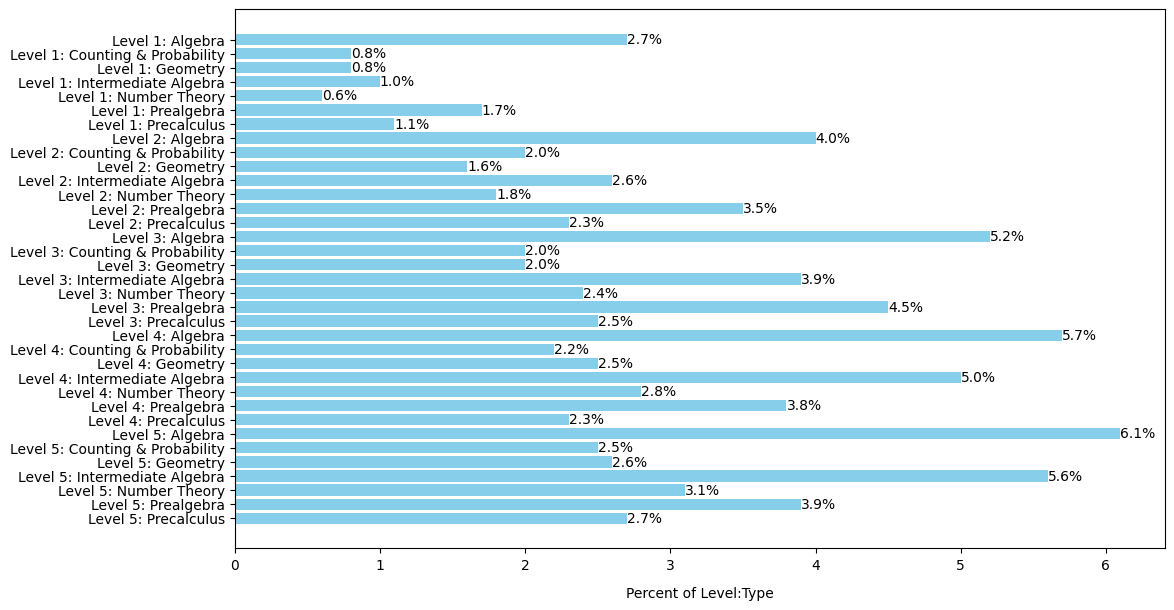

In [8]:
get_competition_math_level_type_distribution().show()

In [16]:
get_competition_math_individual_breakdown()

,Level:Type,Question #s Correct by All Models,Total Correct,Question #s Incorrect by All Models,Total Incorrect,Percent of Level:Type in Dataset
1,Level 1: Algebra,"149, 179, 236, 328, 490, 498, 636, 908, 1000, ...",8%,"1, 4, 13, 19, 24, 64, 65, 70, 83, 84, 100, 102...",92%,2.7
28,Level 1: Prealgebra,"4095, 4119, 4292",3%,"3591, 3594, 3596, 3606, 3607, 3622, 3626, 3634...",97%,1.7
4,Level 2: Algebra,"227, 425, 580, 605, 1139",2%,"5, 12, 16, 22, 41, 42, 44, 67, 72, 76, 79, 82,...",98%,4.0
24,Level 3: Number Theory,"3108, 3238, 3400",2%,"3058, 3059, 3065, 3068, 3074, 3076, 3077, 3088...",98%,2.4
29,Level 3: Prealgebra,"3822, 3972, 4098",1%,"3592, 3593, 3595, 3598, 3600, 3609, 3614, 3621...",99%,4.5
26,Level 2: Prealgebra,"4303, 4369",1%,"3584, 3597, 3602, 3605, 3616, 3617, 3619, 3630...",99%,3.5
7,Level 2: Counting & Probability,1471,1%,"1189, 1198, 1214, 1215, 1220, 1226, 1228, 1230...",99%,2.0
0,Level 3: Algebra,"340, 554",1%,"0, 14, 17, 18, 23, 30, 31, 35, 45, 47, 49, 52,...",99%,5.2
27,Level 4: Prealgebra,3957,1%,"3585, 3589, 3590, 3599, 3601, 3608, 3610, 3613...",99%,3.8
2,Level 4: Algebra,300,0%,"2, 6, 7, 8, 10, 21, 26, 29, 34, 37, 39, 43, 46...",100%,5.7


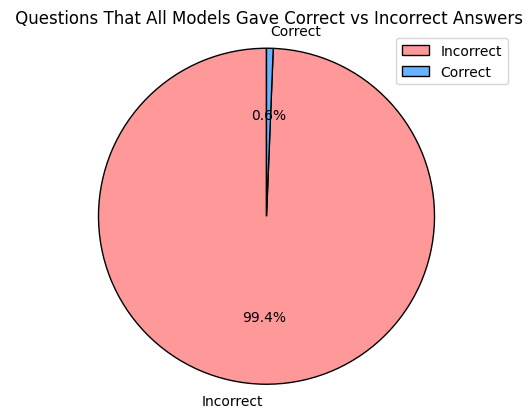

In [10]:
give_ensemble_model_all_correct_piechart().show()

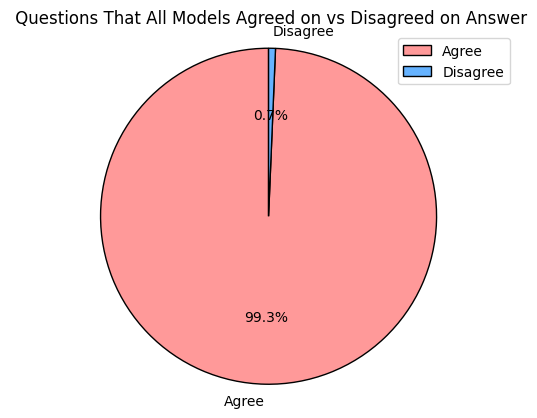

In [13]:
give_ensemble_model_all_agree_piechart().show()